In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved training-set waveforms

In [5]:
# trainset = ws.HDF5WaveformSet('../data/flowp00015/dh_training_set_lhd_uncsamp.hdf5')
# Bamp_filename = '../data/flowp00015/Bamp_lhd_uncsamp.hdf5'
# Bphase_filename = '../data/flowp00015/Bphase_lhd_uncsamp.hdf5'
# amp_gp_filename = '../data/flowp00015/amp_gp_lhd_uncsamp.hdf5'
# phase_gp_filename = '../data/flowp00015/phase_gp_lhd_uncsamp.hdf5'

# trainset = ws.HDF5WaveformSet('../data/flowp00015/dh_training_set_lhd_uncsamp_rand.hdf5')
# Bamp_filename = '../data/flowp00015/Bamp_lhd_uncsamp_rand.hdf5'
# Bphase_filename = '../data/flowp00015/Bphase_lhd_uncsamp_rand.hdf5'
# amp_gp_filename = '../data/flowp00015/amp_gp_lhd_uncsamp_rand.hdf5'
# phase_gp_filename = '../data/flowp00015/phase_gp_lhd_uncsamp_rand.hdf5'

trainset = ws.HDF5WaveformSet('../../data/teobtest/dh_train.hdf5')
Bamp_filename = '../../data/teobtest/B_amp.hdf5'
Bphase_filename = '../../data/teobtest/B_phase.hdf5'
amp_gp_filename = '../../data/teobtest/gp_amp.hdf5'
phase_gp_filename = '../../data/teobtest/gp_phase.hdf5'

32


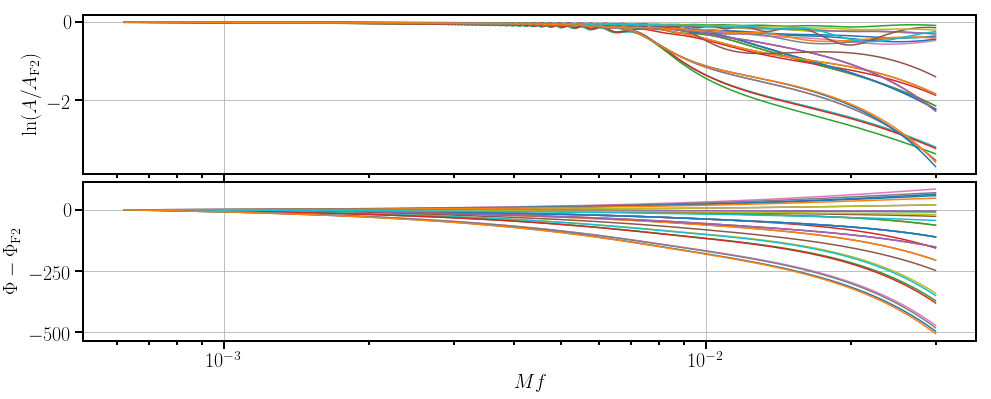

In [6]:
print len(trainset)

fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate reduced Bases for amplitude and phase

In [7]:
epsilon = 1.0e-7

# Initialize the ReducedBasis object
add = surrogate.add_amp
subtract = surrogate.subtract_amp
scalar_multiply = surrogate.scalar_multiply_amp
inner_product = surrogate.inner_product_amp

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.200909104437
0.113037590211
0.0298785563996
0.0138687213419
0.00930032134328
0.00879477463876
0.00301369331311
0.000734111659763
0.000502935845487
0.000470827460905
0.000293411006818
0.000199923695127
8.6943444962e-05
7.04675160281e-05
3.18557594308e-05
1.97257705464e-05
1.59929276013e-05
1.12617957004e-05
6.36063395554e-06
5.06032799252e-06
2.18146004027e-06
4.43517318427e-08


23


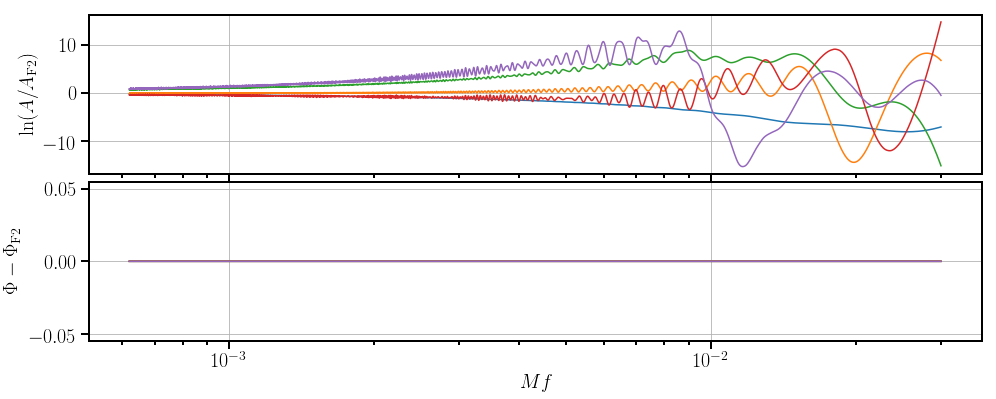

In [8]:
print len(rbamprun.rb)

fig, (ax1, ax2) = wave.plot_waveforms_fd(rbamprun.rb[:5])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

In [9]:
epsilon = 1.0e-11

# Initialize the ReducedBasis object
add = surrogate.add_phase
subtract = surrogate.subtract_phase
scalar_multiply = surrogate.scalar_multiply_phase
inner_product = surrogate.inner_product_phase

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.0532251028678
0.00923187951888
6.85053046545e-05
3.41042778499e-05
2.86380836431e-05
1.20641152124e-06
7.90862957678e-07
5.17243710196e-07
1.99745609941e-07
1.28045645975e-07
7.21435263751e-08
3.67007079172e-08
2.8782858652e-08
2.2001961586e-08
1.13012066372e-08
4.30682822739e-09
2.8479706371e-09
1.62262914216e-09
1.2912867442e-09
4.1266445816e-10
2.32410646284e-10
1.3050116543e-11
3.27926574784e-12


24


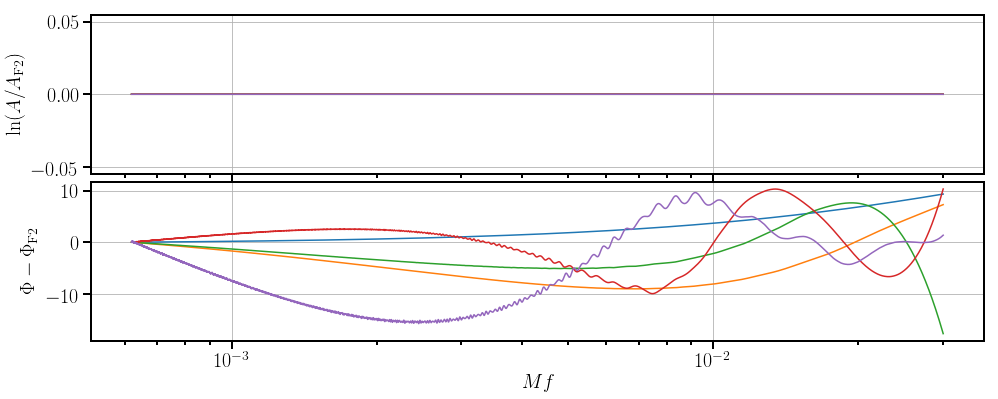

In [10]:
print len(rbphaserun.rb)

fig, (ax1, ax2) = wave.plot_waveforms_fd(rbphaserun.rb[:5])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Empirical interpolating functions

In [11]:
def save_empirical_interpolating_function_list(filename, b_j, mf_node):
    """Save the empirical interpolating functions as a HDF5WaveformSet object.
    The parameter value associated with each function b_j is the frequency of the node mf_j.
    
    Parameters
    ----------
    filename : string
    b_j : list of Waveform objects
        Empirical interpolating functions.
    mf_node : List of floats
        Frequency associated with each empirical interpolating function b_j.
    """
    bset = ws.HDF5WaveformSet(filename)
    
    for j in range(len(b_j)):
        # b_j don't have waveform parameters associated with them,
        # but you do want to save the node frequency node_mf 
        parameters = np.array([mf_node[j]])
        bset.set_waveform(j, b_j[j], parameters)
    
    bset.close()

In [12]:
# Use the first 20 bases
namp = 20
nphase = 20
empirical_node_indices_amp, Bamp_j = surrogate.empirical_interpolation_for_time_domain_waveform(
    rbamprun.rb[:namp], 'amp')
empirical_node_indices_phase, Bphase_j = surrogate.empirical_interpolation_for_time_domain_waveform(
    rbphaserun.rb[:nphase], 'phase')

In [13]:
# Get the frequencies Mf at each empirical node, and sort B's by the node frequency.

# amp
mf_amp = Bamp_j[0].x[empirical_node_indices_amp]
mf_Bamp_list = [[mf_amp[i], Bamp_j[i]] for i in range(len(mf_amp))]
mf_Bamp_list_sorted = sorted(mf_Bamp_list, key=lambda x: x[0])

# phase
mf_phase = Bphase_j[0].x[empirical_node_indices_phase]
mf_Bphase_list = [[mf_phase[i], Bphase_j[i]] for i in range(len(mf_phase))]
mf_Bphase_list_sorted = sorted(mf_Bphase_list, key=lambda x: x[0])

In [14]:
# Save Amplitude and phase empirical interpolants

mf = [mf_Bamp_list_sorted[i][0] for i in range(len(mf_Bamp_list_sorted))]
B_j = [mf_Bamp_list_sorted[i][1] for i in range(len(mf_Bamp_list_sorted))]
save_empirical_interpolating_function_list(Bamp_filename, B_j, mf)

mf = [mf_Bphase_list_sorted[i][0] for i in range(len(mf_Bphase_list_sorted))]
B_j = [mf_Bphase_list_sorted[i][1] for i in range(len(mf_Bphase_list_sorted))]
save_empirical_interpolating_function_list(Bphase_filename, B_j, mf)

In [15]:
# Now load them
Bamp_j = ws.HDF5WaveformSet(Bamp_filename)
Bphase_j = ws.HDF5WaveformSet(Bphase_filename)

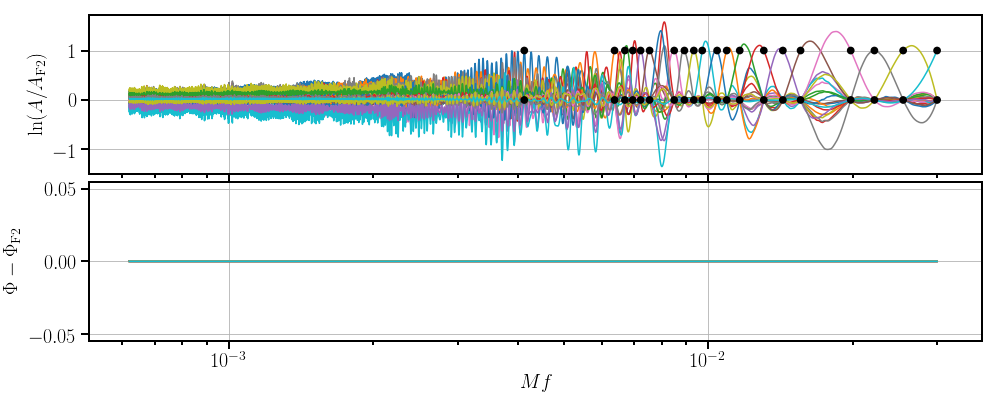

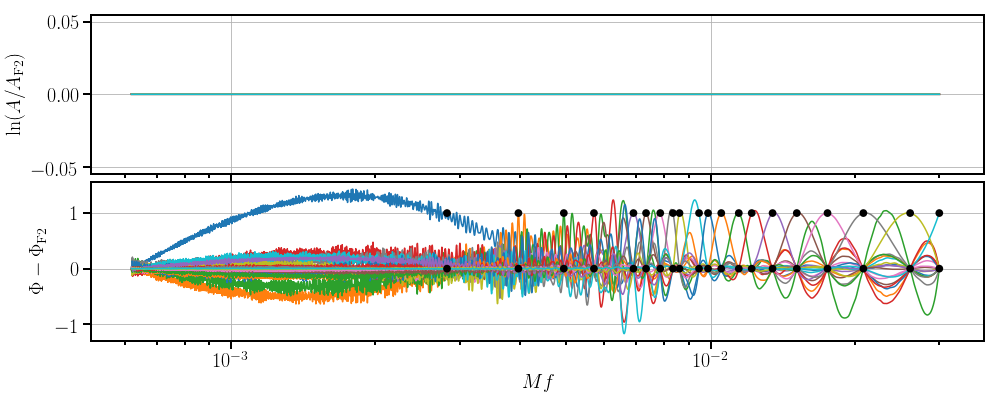

In [16]:
hs = [Bamp_j[j] for j in range(len(Bamp_j))]
mfs = np.array([Bamp_j.get_waveform(j, data='parameters')[0] for j in range(len(Bamp_j))])
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
# zorder is order in which figure is drawn (placed on top of previous figures)
ax1.scatter(mfs, 0*mfs, marker='o', c='k', s=60, edgecolor='none', zorder=100)
ax1.scatter(mfs, 0*mfs+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)

ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

hs = [Bphase_j[j] for j in range(len(Bphase_j))]
mfs = np.array([Bphase_j.get_waveform(j, data='parameters')[0] for j in range(len(Bphase_j))])
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
# zorder is order in which figure is drawn (placed on top of previous figures)
ax2.scatter(mfs, 0*mfs, marker='o', c='k', s=60, edgecolor='none', zorder=100)
ax2.scatter(mfs, 0*mfs+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)

ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Gaussian processes

In [17]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(Bamp_j)):
    mf = Bamp_j.get_waveform(j, data='parameters')[0]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(Bphase_j)):
    mf = Bphase_j.get_waveform(j, data='parameters')[0]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()

In [18]:
#print dphase_ts_list[-1]

In [19]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'

damp_gp_list = []
for i in range(len(damp_ts_list)):
    print i
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
    print gpr.get_hyperparameters(damp_gp)
    damp_gp_list.append(damp_gp)

0
[  4.41468777e-02   2.15404547e+00   1.53704571e+00   1.01969264e+00
   1.35105759e+04   4.00000000e+04   3.88399621e-03]
1
[  1.25858081e-01   9.31514662e-01   2.24443644e+00   5.22946204e+00
   8.11249823e+03   4.00000000e+04   1.46325603e-02]
2
[  1.43723991e-01   1.05026265e+00   3.01933855e+00   5.60000000e+00
   8.66166987e+03   4.00000000e+04   1.60319698e-02]
3
[  1.52827384e-01   8.48970967e-01   2.81417823e+00   4.78842249e+00
   9.23940960e+03   4.00000000e+04   9.75387426e-03]
4
[  1.66686136e-01   8.43375851e-01   3.09460189e+00   5.60000000e+00
   5.21585547e+03   4.00000000e+04   1.28689836e-02]
5
[  1.94260414e-01   6.91840119e-01   3.96772551e+00   5.60000000e+00
   3.95324922e+03   4.00000000e+04   1.62735976e-02]
6
[  3.64692952e-01   5.11908063e-01   5.60000000e+00   5.60000000e+00
   4.55679862e+03   4.00000000e+04   1.14457077e-02]
7
[  4.84252255e-01   5.49375653e-01   5.60000000e+00   5.60000000e+00
   4.69657233e+03   4.00000000e+04   1.57791834e-02]
8
[  4.8

In [20]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, length_scale_factor=[0.1, 10.0], 
                                                             sigma_n_factor=[1.0e-6, 0.1])
    #print hyper_limits
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
    print gpr.get_hyperparameters(dphase_gp)
    dphase_gp_list.append(dphase_gp)

0
[[  4.72687008e+00   1.89074803e+02]
 [  6.66666667e-02   6.66666667e+00]
 [  1.40000000e-01   1.40000000e+01]
 [  1.40000000e-01   1.40000000e+01]
 [  1.00000000e+03   1.00000000e+05]
 [  1.00000000e+03   1.00000000e+05]
 [  4.72687008e-05   4.72687008e+00]]
[  5.98740266e+01   1.11125237e+00   8.42149236e+00   1.40000000e+01
   8.31690366e+03   3.85026409e+04   4.72687008e-05]
1
[[  7.15237638e+00   2.86095055e+02]
 [  6.66666667e-02   6.66666667e+00]
 [  1.40000000e-01   1.40000000e+01]
 [  1.40000000e-01   1.40000000e+01]
 [  1.00000000e+03   1.00000000e+05]
 [  1.00000000e+03   1.00000000e+05]
 [  7.15237638e-05   7.15237638e+00]]
[  8.87718549e+01   1.09789968e+00   8.45259585e+00   1.40000000e+01
   8.13159712e+03   3.77208113e+04   7.15237638e-05]
2
[[  9.15442448e+00   3.66176979e+02]
 [  6.66666667e-02   6.66666667e+00]
 [  1.40000000e-01   1.40000000e+01]
 [  1.40000000e-01   1.40000000e+01]
 [  1.00000000e+03   1.00000000e+05]
 [  1.00000000e+03   1.00000000e+05]
 [  9.15

In [21]:
# Save GPR functions
gpr.save_gaussian_process_regression_list(amp_gp_filename, damp_gp_list, 'matern52')
gpr.save_gaussian_process_regression_list(phase_gp_filename, dphase_gp_list, 'matern52')

# Diagnosing GP fit

In [22]:
def symlog_yticks(axes):
    decade = np.array([0.1*i for i in range(10)])
    ticks = []
    for i in range(-1, 2):
        ticks.append(decade*10**i)
    ticks = np.concatenate(np.array(ticks))
    ticks_rev = np.flip(ticks, 0)
    all_ticks = np.concatenate((-ticks_rev, ticks)) 
    axes.set_yticks(all_ticks, minor=True)
    #axes.set_yticks(all_ticks)

In [22]:
dh_testset_uni = ws.HDF5WaveformSet('../data/dh_test_set_uniform_p00015.hdf5')

[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
   1.00000000e+03]


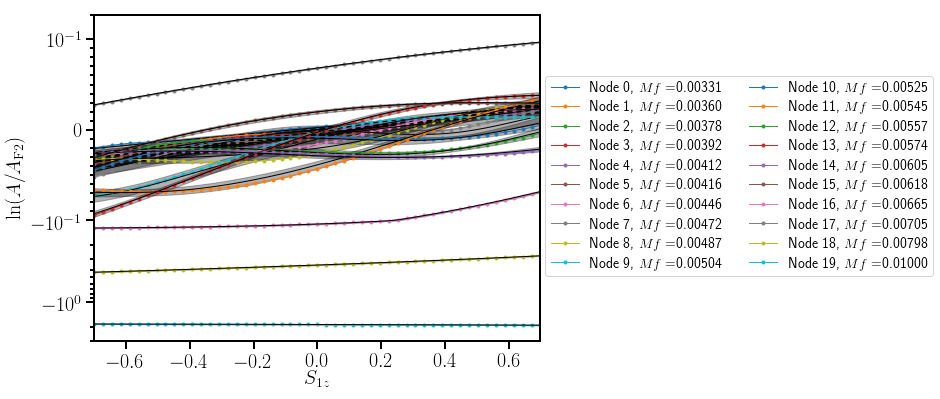

In [23]:
params_test = dh_testset_uni.parameters()
print params_test[0]

fig, axes = plt.subplots(1, figsize=(8, 6))
for j in range(len(damp_gp_list)):
    # Node frequency
    mf = Bamp_j.get_waveform(j, data='parameters')[0]
    
    # Values at node mf for test set and GP prediction/error
    damp_test = np.array([dh_testset_uni[i].interpolate('amp')(mf) for i in range(len(dh_testset_uni))])
    damp_gp = damp_gp_list[j]
    damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_test, return_std=True)
    
    axes.plot(params_test[:, 1], damp_test, 'o', ls='-', lw=1, ms=3,
             label='Node {}, $Mf=${:.5f}'.format(j, mf))
    axes.plot(params_test[:, 1], damp_gp_eval, ls='-', lw=1, c='k')
    axes.fill_between(params_test[:, 1], damp_gp_eval-damp_gp_eval_err, damp_gp_eval+damp_gp_eval_err, 
                      color='k', alpha=0.3)

axes.set_yscale('symlog', linthreshy=0.1)
#axes.set_yticks(ticks, minor=True)
symlog_yticks(axes)
axes.set_ylim(-3, 0.2)
axes.set_xlim(-0.7, 0.7)
axes.set_ylim()
axes.set_ylabel(r'$\ln(A/A_{\rm F2})$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc=(1.01, 0.2), ncol=2)

[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
   1.00000000e+03]


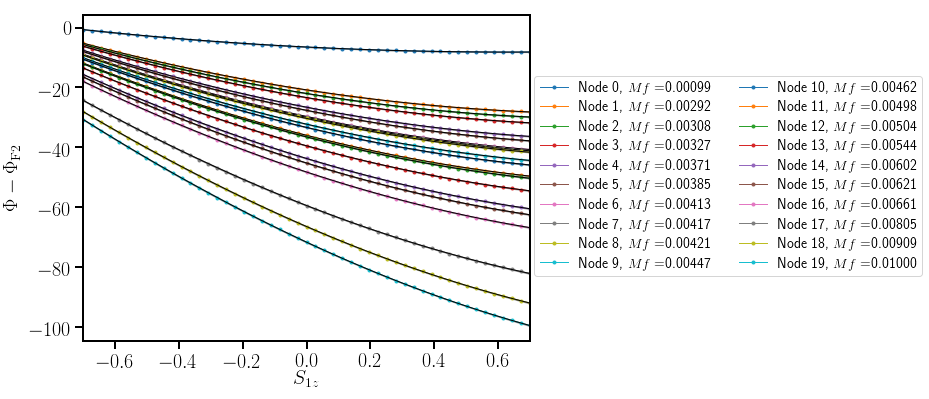

In [24]:
params_test = dh_testset_uni.parameters()
print params_test[0]

fig, axes = plt.subplots(1, figsize=(8, 6))
for j in range(len(dphase_gp_list)):
    # Node frequency
    mf = Bphase_j.get_waveform(j, data='parameters')[0]
    
    # Values at node mf for test set and GP prediction/error
    dphase_test = np.array([dh_testset_uni[i].interpolate('phase')(mf) for i in range(len(dh_testset_uni))])
    dphase_gp = dphase_gp_list[j]
    dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_test, return_std=True)
    
    axes.plot(params_test[:, 1], dphase_test, 'o', ls='-', lw=1, ms=3,
             label='Node {}, $Mf=${:.5f}'.format(j, mf))
    axes.plot(params_test[:, 1], dphase_gp_eval, ls='-', lw=1, c='k')
    axes.fill_between(params_test[:, 1], dphase_gp_eval-dphase_gp_eval_err, dphase_gp_eval+dphase_gp_eval_err, 
                      color='k', alpha=0.3)

axes.set_xlim(-0.7, 0.7)
axes.set_ylim()
axes.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc=(1.01, 0.2), ncol=2)

# Diagnostics (Everything below should go in separate notebooks)

# Plot frequency dependent error estimates

In [167]:
# Bamp_filename = '../data/Bamp.hdf5'
# Bphase_filename = '../data/Bphase.hdf5'
# damp_gp_filename = '../data/amp_gp.hdf5'
# dphase_gp_filename = '../data/phase_gp.hdf5'

# Bamp = ws.HDF5WaveformSet(Bamp_filename)
# Bphase = ws.HDF5WaveformSet(Bphase_filename)
# damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
# dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)

In [168]:
def error_of_frequency(point, B_j, gp_list, data='amp'):
    jmax = len(B_j)
    eps_f_j = np.array([gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                        for j in range(jmax)])
    
    # Get complex version of B_j's in array form
    if data=='amp':
        B_j_array = np.array([B_j[j].amp for j in range(jmax)])
    elif data=='phase':
        B_j_array = np.array([B_j[j].phase for j in range(jmax)])
    else:
        raise Exception

    # Evaluate waveform
    error_arr = np.dot(eps_f_j, B_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = B_j[0].x
    return xarr, error_arr

In [177]:
point = np.array([0.8, 0.3, 0.7, 3455, 2579])
f, eps = error_of_frequency(point, Bamp, damp_gp_list, data='amp')
#f, eps = error_of_frequency(point, Bphase, dphase_gp_list, data='phase')

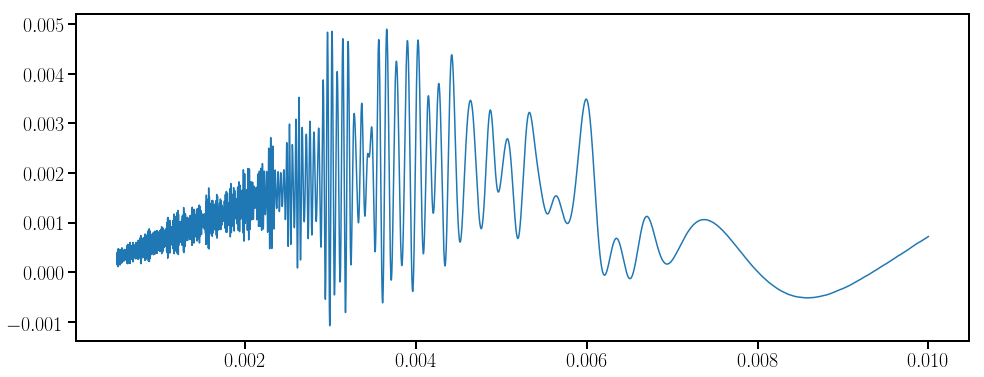

In [178]:
fig, ax1 = plt.subplots(1, figsize=(16, 6))
ax1.plot(f, eps)
#ax1.set_xscale('log')
#ax1.set_xlim(1.0e-4, 0.1)

0.00304761357728


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


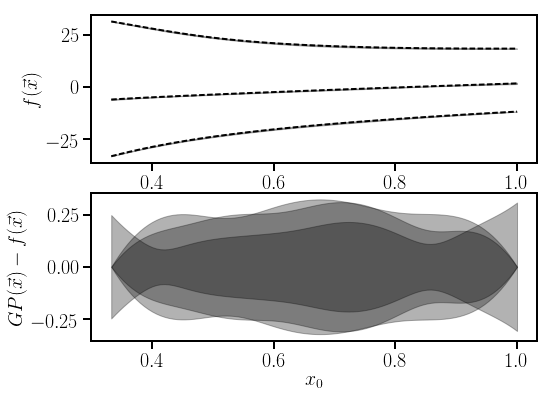

In [184]:
#x2, x3, x4 = 0.0, 2000.0, 2000.0
#x0, x1, x2, x3, x4 = params_rand[i_phasemax]
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0.0, 0.0
i = 2
mf = Bphase_j.get_waveform(i, data='parameters')[0]
print mf
gp = dphase_gp_list[i]

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(-0.7, 0.7, 3):
    x0s = np.linspace(1.0/3.0, 1.0, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    #true = np.array([func(p) for p in ps])
    #ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(x0s, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(x0s, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    #ax[1].plot(x0s, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(x0s, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))